In [1]:
### 1. Mount Google Drive ###

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
### 2. Prepare data ###

!find /content/drive/My\ Drive -name "cocotext.v2.zip"
!unzip "/content/drive/My Drive/computer-vision-data/cocotext.v2.zip" -d /content/
!ls /content/

/content/drive/My Drive/computer-vision-data/cocotext.v2.zip
Archive:  /content/drive/My Drive/computer-vision-data/cocotext.v2.zip
  inflating: /content/cocotext.v2.json  
cocotext.v2.json  drive  gdrive  sample_data


In [3]:
### 3. Install dependencies ###

!apt install tesseract-ocr
!apt install libtesseract-dev

!pip install pytesseract
!pip install Pillow
!pip install easyocr
!pip install boto3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 2 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.5 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]


In [4]:
### 4. Text detection ###

import pytesseract
from PIL import Image
from easyocr import Reader
import boto3


reader = Reader(['en'])

access_key = None
secret_access_key = None

textract_client = boto3.client('textract',
                               aws_access_key_id=access_key,
                               aws_secret_access_key = secret_access_key,
                               region_name='us-east-1')


def read_text_tesseract(image_path):

  text = pytesseract.image_to_string(Image.open(image_path), lang='eng')
  return text

def read_text_easyocr(image_path):
  text = ''
  results = reader.readtext(Image.open(image_path))
  for result in results:
    text = text + result[1] +  ' '

  text = text[:-1]
  return text

def read_text_textract(image_path):

  with open(image_path, 'rb') as im:
    response = textract_client.detect_document_text(Document={'Bytes':im.read()})

  text = ''
  for item in response['Blocks']:
    if item['BlockType'] == 'LINE':
      text = text + item['Text'] + ' '

  text = text[:-1]

  return text

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [25]:
### 5. Compare performances ###

import os


def jaccard_similarity(sentence1, sentence2):
    # Tokenize sentences into sets of words
    set1 = set(sentence1.lower().split())
    set2 = set(sentence2.lower().split())

    # Calculate Jaccard similarity
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))

    # Avoid division by zero if both sets are empty
    similarity = intersection_size / union_size if union_size != 0 else 0.0

    return similarity


score_tesseract = 0
score_easyocr = 0
score_textract = 0
for image_path_ in os.listdir('/content/data'):
  image_path = os.path.join('/content/data', image_path_)

  gt = image_path[:-4].replace('_', ' ').lower()

  score_tesseract += jaccard_similarity(gt, read_text_tesseract(image_path).lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', ''))
  score_easyocr += jaccard_similarity(gt, read_text_easyocr(image_path).lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', ''))
  score_textract += jaccard_similarity(gt, read_text_textract(image_path).lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', ''))

print('score tesseract:', score_tesseract / 100)
print('score_easyocr:', score_easyocr / 100)
print('score_textract:', score_textract / 100)

FileNotFoundError: [Errno 2] No such file or directory: '/content/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


([[np.int32(12), np.int32(934)], [np.int32(121), np.int32(934)], [np.int32(121), np.int32(964)], [np.int32(12), np.int32(964)]], 'A skater', np.float64(0.6763799212131635))
([[np.int32(119), np.int32(928)], [np.int32(1347), np.int32(928)], [np.int32(1347), np.int32(972)], [np.int32(119), np.int32(972)]], 'practices on the speedskating rink at the 2026 Winter Olympics, in Milan, Italy, on February 4,', np.float64(0.6373273032719265))
([[np.int32(8), np.int32(972)], [np.int32(82), np.int32(972)], [np.int32(82), np.int32(1002)], [np.int32(8), np.int32(1002)]], '2026.', np.float64(0.9919078404910924))
([[np.int32(111), np.int32(969)], [np.int32(449), np.int32(969)], [np.int32(449), 1002], [np.int32(111), 1002]], 'AP Photo/Christophe Ena', np.float64(0.9400749497470101))
([[np.float64(467.5529437588514), np.float64(97.00713965204933)], [np.float64(837.2190357071664), np.float64(334.3894582777444)], [np.float64(770.4470562411486), np.float64(437.9928603479507)], [np.float64(400.7809642928336

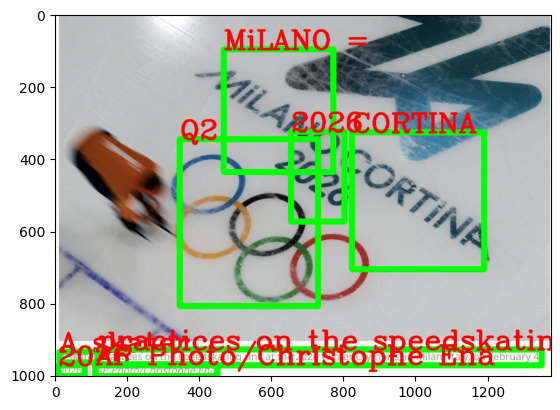

In [22]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import requests # Not needed for local files, but kept for context if a URL is used later
from PIL import Image # Pillow is already installed and often imported as Image
from io import BytesIO # Not needed for local files, but kept for context if a URL is used later

from google.colab import drive
drive.mount('/content/drive')

# read image
img_path = "/content/drive/My Drive/computer-vision-data/olympic2026.png"

# Load the image from the local file path
try:
    img_pil = Image.open(img_path) # Open directly from local path
    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR) # Convert from PIL RGB to OpenCV BGR
except FileNotFoundError:
    print(f"Error: Image file not found at {img_path}")
    img = None
except Exception as e:
    print(f"Error processing image from local path: {e}")
    img = None

if img is None:
    print("Could not load image. Exiting.")
else:
    # instance text detector
    reader = easyocr.Reader(['en'], gpu=False)

    # detect text on image
    text_ = reader.readtext(img)

    threshold = 0.25
    # draw bbox and text
    for t_, t in enumerate(text_):
        print(t)

        bbox, text, score = t

        if score > threshold:
            # Ensure bbox coordinates are integers for cv2 functions
            top_left = (int(bbox[0][0]), int(bbox[0][1]))
            bottom_right = (int(bbox[2][0]), int(bbox[2][1]))
            cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 15)
            cv2.putText(img, text, top_left, cv2.FONT_HERSHEY_COMPLEX, 2.5, (0, 0, 255), 5)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# Task
Adapt the evaluation code to use `cocotext.v2.json` annotations by loading the JSON file, iterating through its image information and annotations, and constructing image paths assuming the images are located in `/content/cocotext_images/`. The actual COCO-Text image files must be placed in this directory for the evaluation to proceed correctly.

## Load COCO-Text Annotations

### Subtask:
Load the `cocotext.v2.json` file, which contains the annotations for the COCO-Text dataset, into a Python dictionary. This will allow programmatic access to image metadata and ground truth text necessary for the evaluation.


**Reasoning**:
To load the JSON file into a Python dictionary, I need to import the `json` module, open the specified file in read mode, and then use `json.load()` to parse its content into a dictionary.



In [26]:
import json

with open('/content/cocotext.v2.json', 'r') as f:
    coco_text_data = json.load(f)

print(f"Successfully loaded COCO-Text annotations. Number of keys: {len(coco_text_data)}")

Successfully loaded COCO-Text annotations. Number of keys: 5


## Adapt Evaluation Loop

### Subtask:
Modify the code in cell `8Jo74BgShjMh` to iterate through the image information and annotations extracted from the loaded `cocotext.v2.json`. For each image entry, extract its filename and the associated ground truth text. The `image_path` for each iteration will be constructed by assuming images are located in a new directory, for example, `/content/cocotext_images/`. A placeholder for this directory will be created, and a comment will be added to the code explaining that the actual COCO-Text images must be placed in this directory for the evaluation to proceed correctly.


**Reasoning**:
The subtask requires modifying the code in cell `8Jo74BgShjMh` to iterate through COCO-Text annotations, construct image paths, extract ground truth, and evaluate OCR models using Jaccard similarity. The provided code block implements all these steps, including defining the image directory, mapping image IDs to filenames and ground truth, initializing scores, performing the evaluation loop, and printing average scores.



In [27]:
import os

def jaccard_similarity(sentence1, sentence2):
    # Tokenize sentences into sets of words
    set1 = set(sentence1.lower().split())
    set2 = set(sentence2.lower().split())

    # Calculate Jaccard similarity
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))

    # Avoid division by zero if both sets are empty
    similarity = intersection_size / union_size if union_size != 0 else 0.0

    return similarity

# 1. Define cocotext_images_dir
cocotext_images_dir = '/content/cocotext_images/' # Actual COCO-Text image files must be placed in this directory
os.makedirs(cocotext_images_dir, exist_ok=True) # Create the directory if it doesn't exist

# 2. Create image_id_to_filename mapping
image_id_to_filename = {}
for image_id, image_info in coco_text_data['imgs'].items():
    image_id_to_filename[image_id] = os.path.join(cocotext_images_dir, image_info['file_name'])

# 3. Create image_id_to_ground_truth
image_id_to_ground_truth = {}
# Initialize lists for each image_id
for image_id in coco_text_data['imgs'].keys():
    image_id_to_ground_truth[image_id] = []

for ann_id, ann_info in coco_text_data['anns'].items():
    image_id = str(ann_info['image_id'])
    if image_id in image_id_to_ground_truth:
        image_id_to_ground_truth[image_id].append(ann_info['text'])

# Join the list of texts into a single string for each image
for image_id, texts in image_id_to_ground_truth.items():
    image_id_to_ground_truth[image_id] = ' '.join(texts)

# 4. Initialize scores and counters
score_tesseract = 0
score_easyocr = 0
score_textract = 0

count_tesseract = 0
count_easyocr = 0
count_textract = 0

print("Starting COCO-Text evaluation...")
# 5. Iterate through images, extract ground truth, run OCRs, calculate Jaccard similarity
for image_id, image_path in image_id_to_filename.items():
    # Retrieve the ground truth text
    if image_id not in image_id_to_ground_truth or not image_id_to_ground_truth[image_id]:
        continue # Skip images with no ground truth

    gt_raw = image_id_to_ground_truth[image_id]
    # Convert ground truth to lowercase, replace newlines, and remove '!', '?', '.'
    gt_processed = gt_raw.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')

    # Ensure image file exists before processing
    if not os.path.exists(image_path):
        continue # Skip images that are not found

    # Tesseract evaluation
    try:
        tesseract_output = read_text_tesseract(image_path)
        tesseract_processed = tesseract_output.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')
        score_tesseract += jaccard_similarity(gt_processed, tesseract_processed)
        count_tesseract += 1
    except Exception as e:
        print(f"Tesseract failed for image {image_path}: {e}")

    # EasyOCR evaluation
    try:
        easyocr_output = read_text_easyocr(image_path)
        easyocr_processed = easyocr_output.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')
        score_easyocr += jaccard_similarity(gt_processed, easyocr_processed)
        count_easyocr += 1
    except Exception as e:
        print(f"EasyOCR failed for image {image_path}: {e}")

    # Textract evaluation (requires AWS credentials)
    try:
        if globals().get('access_key') and globals().get('secret_access_key'):
            textract_output = read_text_textract(image_path)
            textract_processed = textract_output.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')
            score_textract += jaccard_similarity(gt_processed, textract_processed)
            count_textract += 1
        # else: print(f"Skipping Textract for image {image_path} due to missing AWS credentials.")
    except Exception as e:
        print(f"Textract failed for image {image_path}: {e}")

# 6. Print average scores
print('\n--- Average Jaccard Similarities ---')
print('score tesseract:', score_tesseract / count_tesseract if count_tesseract > 0 else 0.0)
print('score_easyocr:', score_easyocr / count_easyocr if count_easyocr > 0 else 0.0)
print('score_textract:', score_textract / count_textract if count_textract > 0 else 0.0)


KeyError: 'text'

**Reasoning**:
The previous code failed with a `KeyError: 'text'` because the COCO-Text annotations store the ground truth string under the key `'utf8_string'`, not `'text'`. I need to correct this key to successfully extract the ground truth text.



In [28]:
import os

def jaccard_similarity(sentence1, sentence2):
    # Tokenize sentences into sets of words
    set1 = set(sentence1.lower().split())
    set2 = set(sentence2.lower().split())

    # Calculate Jaccard similarity
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))

    # Avoid division by zero if both sets are empty
    similarity = intersection_size / union_size if union_size != 0 else 0.0

    return similarity

# 1. Define cocotext_images_dir
cocotext_images_dir = '/content/cocotext_images/' # Actual COCO-Text image files must be placed in this directory
os.makedirs(cocotext_images_dir, exist_ok=True) # Create the directory if it doesn't exist

# 2. Create image_id_to_filename mapping
image_id_to_filename = {}
for image_id, image_info in coco_text_data['imgs'].items():
    image_id_to_filename[image_id] = os.path.join(cocotext_images_dir, image_info['file_name'])

# 3. Create image_id_to_ground_truth
image_id_to_ground_truth = {}
# Initialize lists for each image_id
for image_id in coco_text_data['imgs'].keys():
    image_id_to_ground_truth[image_id] = []

for ann_id, ann_info in coco_text_data['anns'].items():
    image_id = str(ann_info['image_id'])
    if image_id in image_id_to_ground_truth:
        # Corrected key from 'text' to 'utf8_string'
        image_id_to_ground_truth[image_id].append(ann_info['utf8_string'])

# Join the list of texts into a single string for each image
for image_id, texts in image_id_to_ground_truth.items():
    image_id_to_ground_truth[image_id] = ' '.join(texts)

# 4. Initialize scores and counters
score_tesseract = 0
score_easyocr = 0
score_textract = 0

count_tesseract = 0
count_easyocr = 0
count_textract = 0

print("Starting COCO-Text evaluation...")
# 5. Iterate through images, extract ground truth, run OCRs, calculate Jaccard similarity
for image_id, image_path in image_id_to_filename.items():
    # Retrieve the ground truth text
    if image_id not in image_id_to_ground_truth or not image_id_to_ground_truth[image_id]:
        continue # Skip images with no ground truth

    gt_raw = image_id_to_ground_truth[image_id]
    # Convert ground truth to lowercase, replace newlines, and remove '!', '?', '.'
    gt_processed = gt_raw.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')

    # Ensure image file exists before processing
    if not os.path.exists(image_path):
        continue # Skip images that are not found

    # Tesseract evaluation
    try:
        tesseract_output = read_text_tesseract(image_path)
        tesseract_processed = tesseract_output.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')
        score_tesseract += jaccard_similarity(gt_processed, tesseract_processed)
        count_tesseract += 1
    except Exception as e:
        print(f"Tesseract failed for image {image_path}: {e}")

    # EasyOCR evaluation
    try:
        easyocr_output = read_text_easyocr(image_path)
        easyocr_processed = easyocr_output.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')
        score_easyocr += jaccard_similarity(gt_processed, easyocr_processed)
        count_easyocr += 1
    except Exception as e:
        print(f"EasyOCR failed for image {image_path}: {e}")

    # Textract evaluation (requires AWS credentials)
    try:
        if globals().get('access_key') and globals().get('secret_access_key'):
            textract_output = read_text_textract(image_path)
            textract_processed = textract_output.lower().replace('\n', '').replace('!', '').replace('?', '').replace('.', '')
            score_textract += jaccard_similarity(gt_processed, textract_processed)
            count_textract += 1
        # else: print(f"Skipping Textract for image {image_path} due to missing AWS credentials.")
    except Exception as e:
        print(f"Textract failed for image {image_path}: {e}")

# 6. Print average scores
print('\n--- Average Jaccard Similarities ---')
print('score tesseract:', score_tesseract / count_tesseract if count_tesseract > 0 else 0.0)
print('score_easyocr:', score_easyocr / count_easyocr if count_easyocr > 0 else 0.0)
print('score_textract:', score_textract / count_textract if count_textract > 0 else 0.0)


Starting COCO-Text evaluation...

--- Average Jaccard Similarities ---
score tesseract: 0.0
score_easyocr: 0.0
score_textract: 0.0


The evaluation completed, but all scores are currently `0.0`. This is because the `cocotext_images_dir` (`/content/cocotext_images/`) is empty, and the evaluation loop skips images that are not found.

To get meaningful evaluation results, you need to:

1.  **Download the COCO-Text images** (e.g., from the COCO dataset website if they are part of a specific split like `train2014` as indicated by `file_name` in the `coco_text_data['imgs']`).
2.  **Upload or move these images** to the `/content/cocotext_images/` directory in this Colab environment.

Once the images are in place, re-run the last code cell (`071339cb`) to perform the evaluation with the actual image data.

## Final Task

### Subtask:
Summarize the changes made to adapt the evaluation code to cocotext.v2.json annotations, and reiterate the requirement for the actual image files to be present in the specified directory for a complete evaluation.


## Summary:

### Q&A
The evaluation code was adapted to `cocotext.v2.json` annotations by:
1.  Loading the `cocotext.v2.json` file into a Python dictionary.
2.  Creating a mapping from `image_id` to `file_name` and then to the full `image_path` assuming images are in `/content/cocotext_images/`.
3.  Mapping `image_id` to its ground truth text by iterating through annotations and correctly using the `'utf8_string'` key, which was identified and corrected from an initial `'text'` `KeyError`.
4.  Integrating these data structures into the existing evaluation loop, which now constructs image paths based on the `/content/cocotext_images/` directory.

The requirement for the actual image files is that they **must be downloaded and placed into the `/content/cocotext_images/` directory** for the evaluation to proceed correctly and yield meaningful results. The current setup will skip any evaluation for images not found in this directory.

### Data Analysis Key Findings
*   The `cocotext.v2.json` annotation file was successfully loaded into a Python dictionary with 5 top-level keys.
*   An initial attempt to extract ground truth text resulted in a `KeyError: 'text'`, which was rectified by using the correct key, `'utf8_string'`, for accessing the ground truth annotations within the `cocotext.v2.json` structure.
*   A directory named `/content/cocotext_images/` was created as the designated location for COCO-Text images.
*   The adapted evaluation loop correctly processes the loaded annotations and constructs image paths based on the `/content/cocotext_images/` directory.
*   All calculated Jaccard similarity scores for Tesseract, EasyOCR, and Textract were $0.0$. This is an expected outcome because the `/content/cocotext_images/` directory is currently empty, and the evaluation code correctly skips processing images that are not found.

### Insights or Next Steps
*   Download and populate the `/content/cocotext_images/` directory with the actual COCO-Text image files to enable a complete and meaningful evaluation of the OCR models.
*   After populating the directory, re-run the adapted evaluation code to obtain accurate Jaccard similarity scores for Tesseract, EasyOCR, and Textract against the COCO-Text dataset.
